In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os
import shutil

# Measure the similarity/difference of $M^*$ eigenvectors

The top eigenvectors corresponding to the largest eigenvalues represent directions that are most important to the prediction.
</br>

The question is: are these directions consistent over different combinations of training datapoints (but with the same feature extraction algorithm).
</br>

Moreover, the directions might not be exactly the same, but the space which spans by them might be. That still means there is an "important" subspace of features that is consistently being detected. So the second question is: do these eigenvalues span the same space?

In [2]:
feature_dirs = {'soenet': '../../data/experiments/soenet/soenet_sg/2023_07_17/',
               'slowfast': '../../data/experiments/slowfast/slowfast_sg/2023_05_04-runtime-n/',
               '3dsift': '../../data/experiments/sift3d/sift3d_sg/2023_07_14/'}

# choose your feature
feature_id = '3dsift'
res_path = feature_dirs[feature_id]

# Pilot: Eigenvalues by trainig size

In [3]:
train_sizes = [100, 200, 300, 400, 500, 600]
num_eig = 10 # number of eigenvalues in the plot
num_M = 100 # number of matrices to compute the mean and std for each plot point

eigvals = []
for train_sz in train_sizes:
    for i in range(num_M):
        M = np.load(res_path+'matrices/finalM_50_'+str(train_sz)+'_'+str(i)+'.npy')
        w = np.sort(np.linalg.eigvals(M))
        eigvals.append(w)
    
eigvals = np.array(eigvals)
print('{} eigenvalues are computed in {}x{} matrices and stored in an array of shape '.format(eigvals.shape[1], len(train_sizes), num_M), eigvals.shape)

384 eigenvalues are computed in 6x100 matrices and stored in an array of shape  (600, 384)


In [4]:
# plot average and errors of eigenvalues
curves = []
errors = []
for t in range(len(train_sizes)):
    eigvals_avg = np.mean(eigvals[t*num_M:t*num_M+num_M, :], axis=0)
    eigvals_err = np.std(eigvals[t*num_M:t*num_M+num_M, :], axis=0)
    curves.append(eigvals_avg)
    errors.append(eigvals_err)

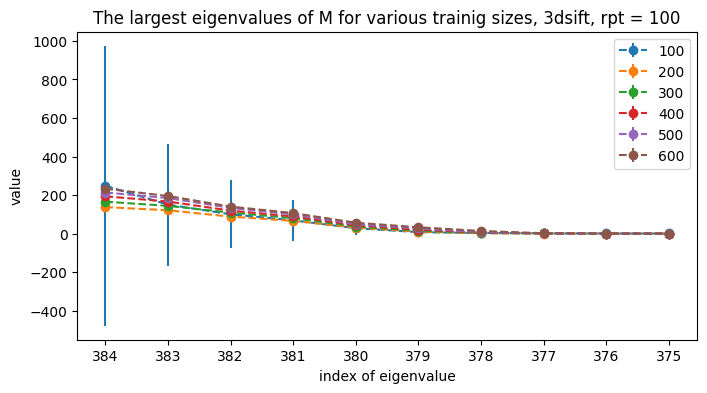

In [5]:
x = eigvals.shape[1] - np.arange(num_eig)
plt.figure(figsize=(8,4))
for t in range(len(train_sizes)):
    plt.errorbar(np.arange(num_eig), np.real(curves[t][-1:-num_eig-1:-1]), np.real(errors[t][-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.legend(train_sizes)
plt.xlabel('index of eigenvalue')
plt.ylabel('value')
plt.title('The largest eigenvalues of M for various trainig sizes, {}, rpt = {}'.format(feature_id, num_M))
plt.savefig('image/eigvals4trainsz.png',dpi=300, bbox_inches = "tight")

# Load eigenvectors of a specific training set size

In [3]:
num_M = 100
train_sz = 200

eigvals = []
eigvecs = []
for i in range(num_M):
    M = np.load(res_path+'matrices/finalM_50_'+str(train_sz)+'_'+str(i)+'.npy')
    vals, vecs = np.linalg.eig(M)
    sorted_vals = sorted(list(zip(np.arange(vals.shape[0]), np.real(vals))), key = lambda x: x[1], reverse=True)
    sorted_vals = np.array(sorted_vals)
    vals_i = sorted_vals[:, 0]
    vals = sorted_vals[:, 1]
    vecs = vecs[vals_i.astype(int)]
    eigvals.append(vals)
    eigvecs.append(vecs)

In [4]:
print('eigvals = a list of {} numpy arrays of shape {}'.format(len(eigvals), eigvals[0].shape))
print('eigvecs = a list of {} numpy arrays of shape {}'.format(len(eigvecs), eigvecs[0].shape))

eigvals = a list of 100 numpy arrays of shape (384,)
eigvecs = a list of 100 numpy arrays of shape (384, 384)


# Visualize loaded eigenvalues and eigenvectors

In [5]:
num_obs = 9 # number of observations to visualize
obs = np.random.choice(np.arange(num_M), size=num_obs, replace=False)
print('Observations to be visualized = ', obs)

Observations to be visualized =  [86 93 35 22  9 16  1 91 37]


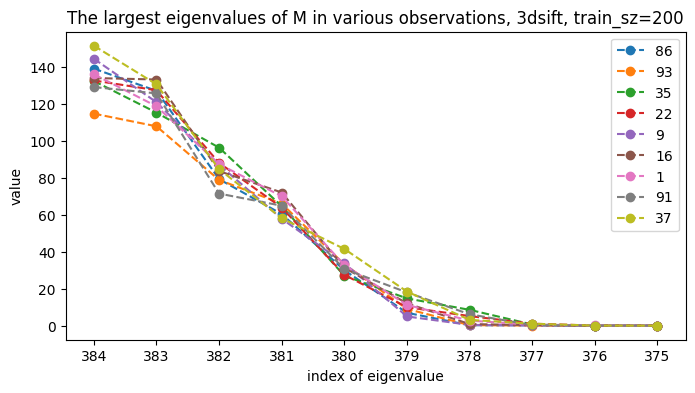

In [6]:
num_eig = 10 # number of eigenvalues in the plot
x = np.arange(num_eig)

plt.figure(figsize=(8,4))
for ob_i in obs:
    plt.plot(x, np.real(eigvals[ob_i][:num_eig]), marker='o', linestyle='--')
_ = plt.xticks(x, eigvals[0].shape[0] - x)
plt.legend(obs)
plt.xlabel('index of eigenvalue')
plt.ylabel('value')
plt.title('The largest eigenvalues of M in various observations, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvals.png',dpi=300, bbox_inches = "tight")

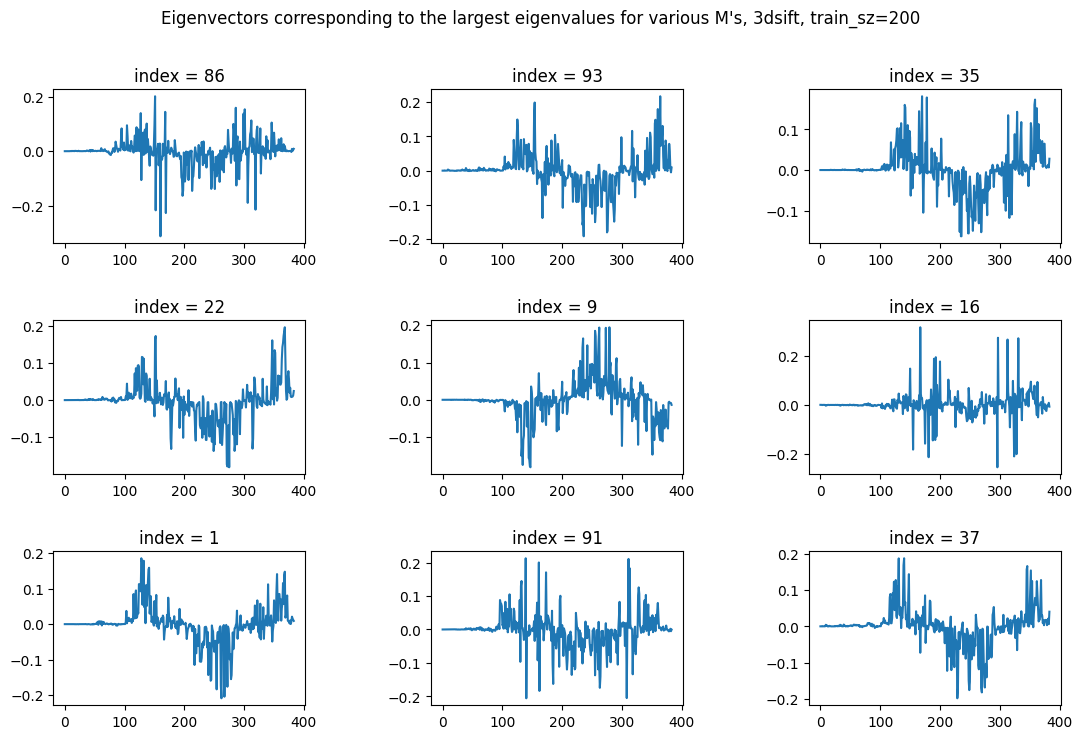

In [7]:
x = np.arange(eigvecs[0].shape[0])
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for ob_i in obs:
    i += 1
    plt.subplot(3,num_obs//3,i)
    plt.plot(x, np.real(eigvecs[ob_i][:, 0]))
    plt.title('index = {}'.format(ob_i))

_ = plt.suptitle('Eigenvectors corresponding to the largest eigenvalues for various M\'s, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

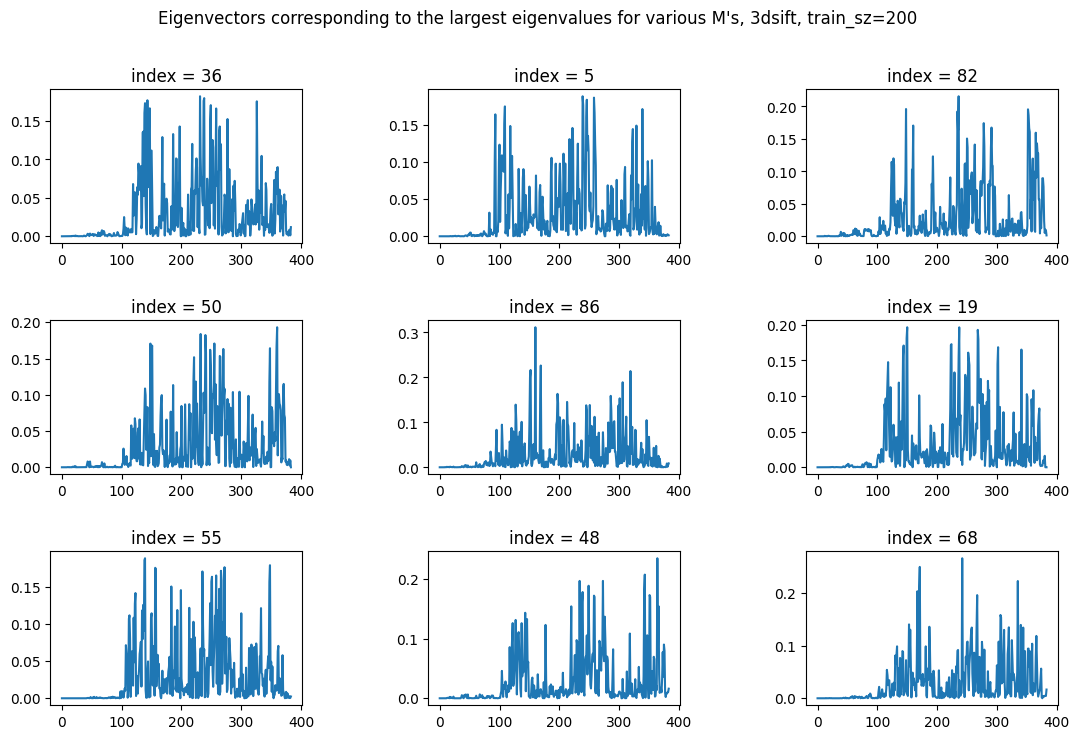

In [11]:
# plot the absolute value of eigenvectors
x = np.arange(eigvecs[0].shape[0])
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for ob_i in obs:
    i += 1
    plt.subplot(3,num_obs//3,i)
    plt.plot(x, np.abs(np.real(eigvecs[ob_i][:, 0])))
    plt.title('index = {}'.format(ob_i))

_ = plt.suptitle('Eigenvectors corresponding to the largest eigenvalues for various M\'s, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvecs-abs.png',dpi=300, bbox_inches = "tight")

## Compute dot products of different observations of one eigenvector

/tmp/ipykernel_11373/3798818236.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  products[i,j] = np.dot(eigvecs[i][:, vect_i], eigvecs[j][:, vect_i])


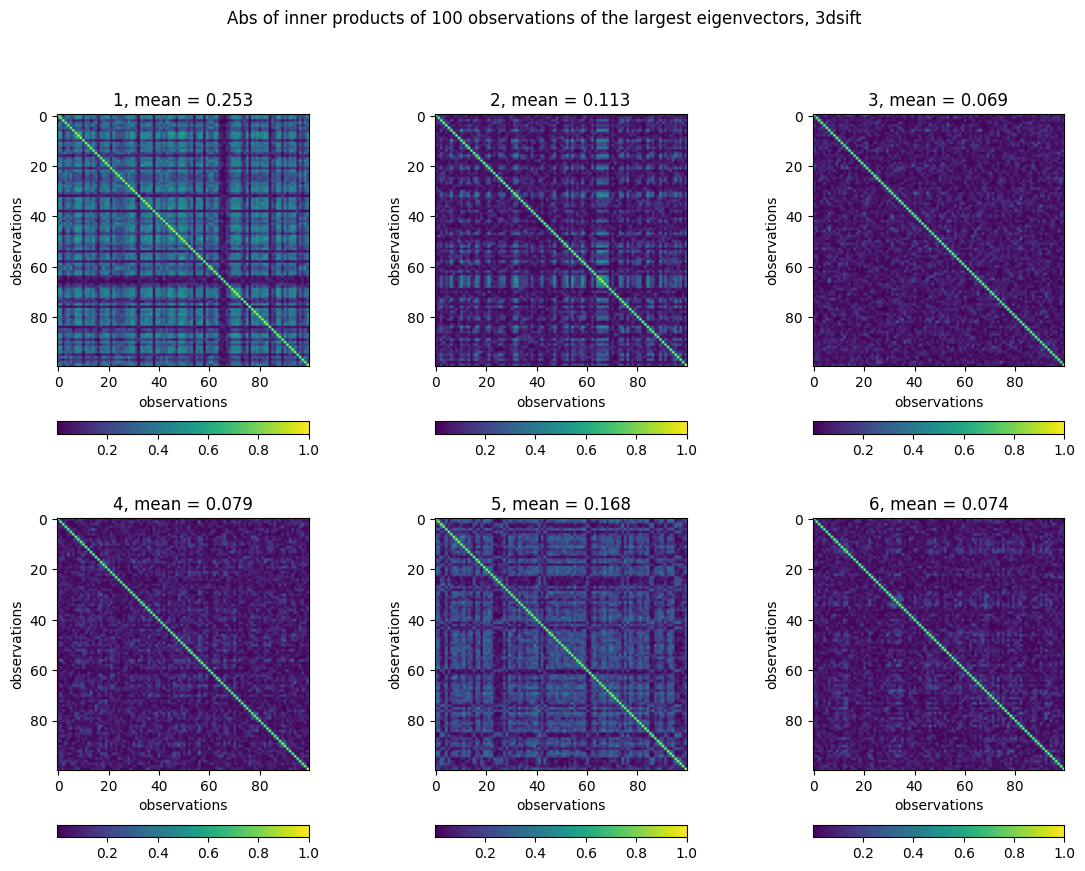

In [12]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    products = np.ones((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            products[i,j] = np.dot(np.real(eigvecs[i][:, vect_i]), np.real(eigvecs[j][:, vect_i]))
            products[j,i] = products[i,j]
            avg += np.abs(products[i,j])
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(np.abs(products))
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('Abs of inner products of {} observations of the largest eigenvectors, {}'.format(num_M, feature_id))
plt.savefig('image/dotproducts.png',dpi=300, bbox_inches = "tight")

## Compute L2 norm of the difference of observations of an eigenvector

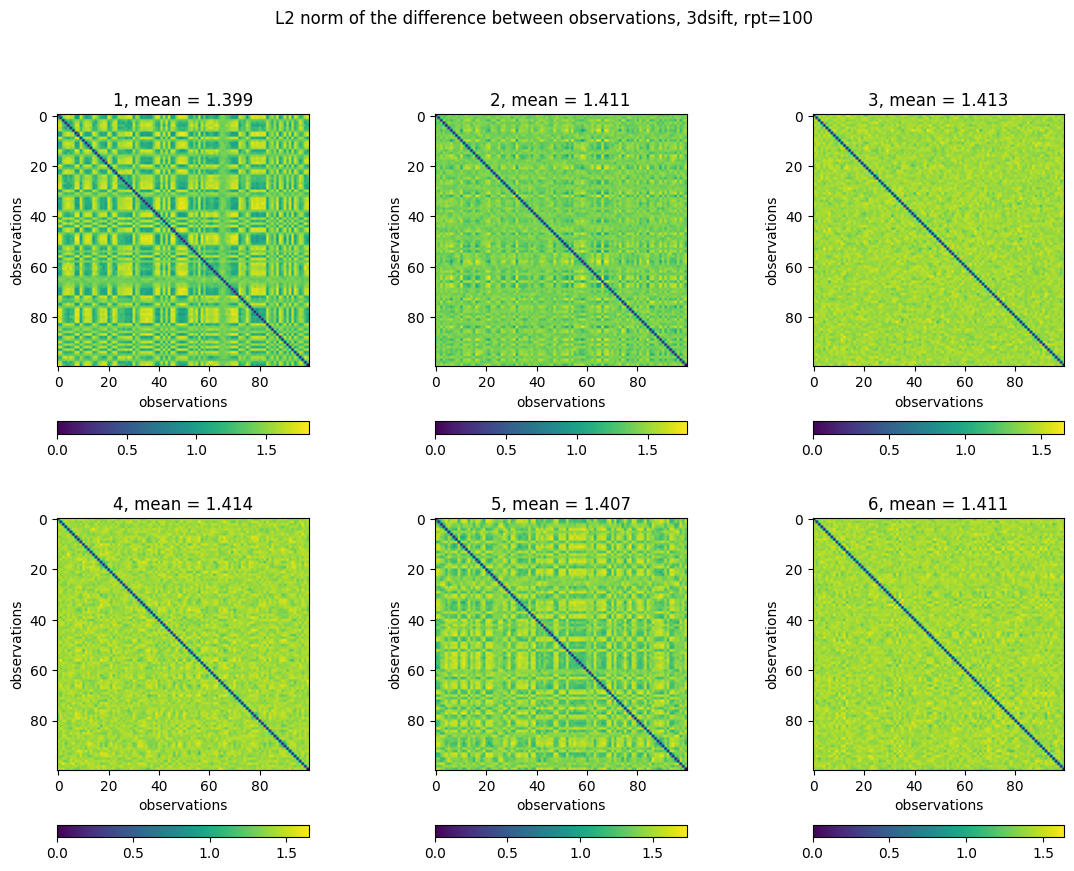

In [13]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    norms = np.zeros((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            norms[i,j] = np.linalg.norm(eigvecs[i][:, vect_i] - eigvecs[j][:, vect_i])
            norms[j,i] = norms[i,j]
            avg += norms[i,j]
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(norms)
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('L2 norm of the difference between observations, {}, rpt={}'.format(feature_id, num_M))
plt.savefig('image/norms.png',dpi=300, bbox_inches = "tight")

## Multiplicity of the largest eigenvalues is 1

In [14]:
for ob_i in range(num_M):
    eigvals_unique, eigvals_unique_counts = np.unique(eigvals[ob_i].round(decimals=8), return_counts=True)
    try:
        assert np.all(eigvals_unique_counts[:-6:-1] == 1)
    except:
        print(ob_i, eigvals_unique_counts[::-1])
        print(ob_i, eigvals_unique[::-1], '\n')

# Take moving average of the eigenvalues

Because the low similarity might be because of small alterations in the location of the most important features.

In [71]:
# the average function
avlength = 5
avfunc = np.ones(avlength) / avlength

eigvecs_smth = []
for ob_i in range(num_M):
    smth = np.zeros(eigvecs[0].shape)
    for vect_i in range(eigvecs[ob_i].shape[1]):
        temp = np.convolve(np.real(eigvecs[ob_i][:,vect_i]), avfunc, mode='same')
        smth[:, vect_i] = temp/np.linalg.norm(temp)
    eigvecs_smth.append(smth)

print('eigvecs_smth = a list of {} numpy arrays of shape {} containing filtered eigenvectors'.format(len(eigvecs_smth), eigvecs_smth[0].shape))

eigvecs_smth = a list of 100 numpy arrays of shape (384, 384) containing filtered eigenvectors


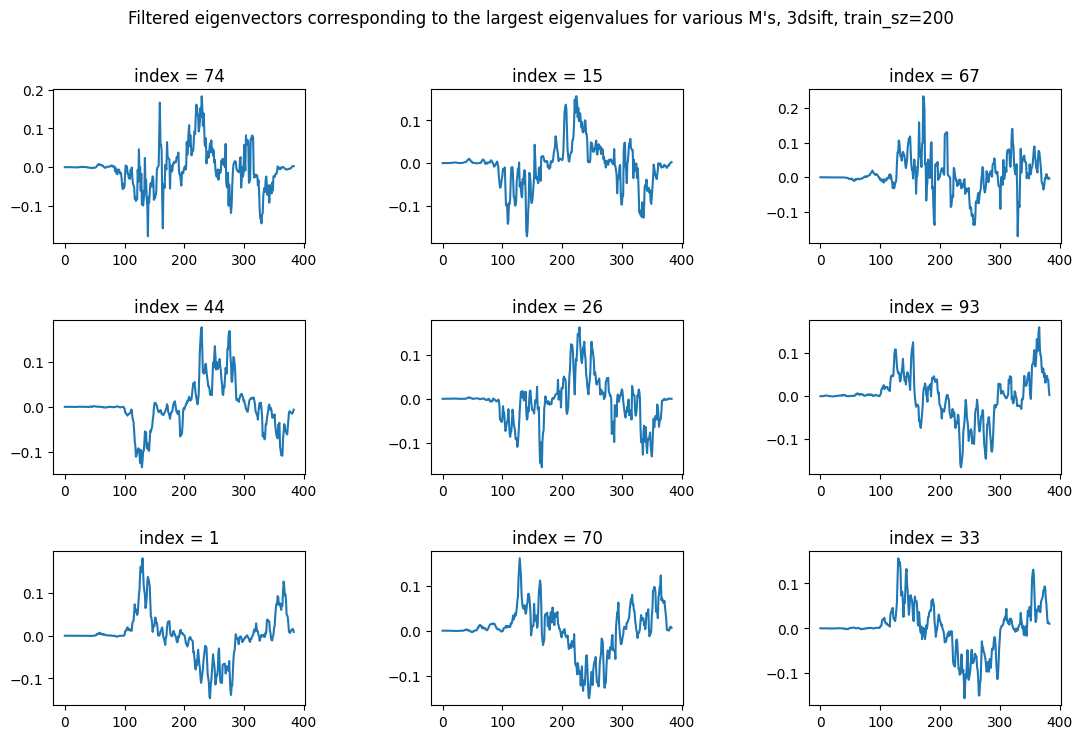

In [72]:
# plot the largest eigenvector of the same observations
x = np.arange(eigvecs_smth[0].shape[0])
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for ob_i in obs:
    i += 1
    plt.subplot(3,num_obs//3,i)
    plt.plot(x, eigvecs_smth[ob_i][:, 0])
    plt.title('index = {}'.format(ob_i))

_ = plt.suptitle('Filtered eigenvectors corresponding to the largest eigenvalues for various M\'s, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

## Compute dot products of different observations of one eigenvector

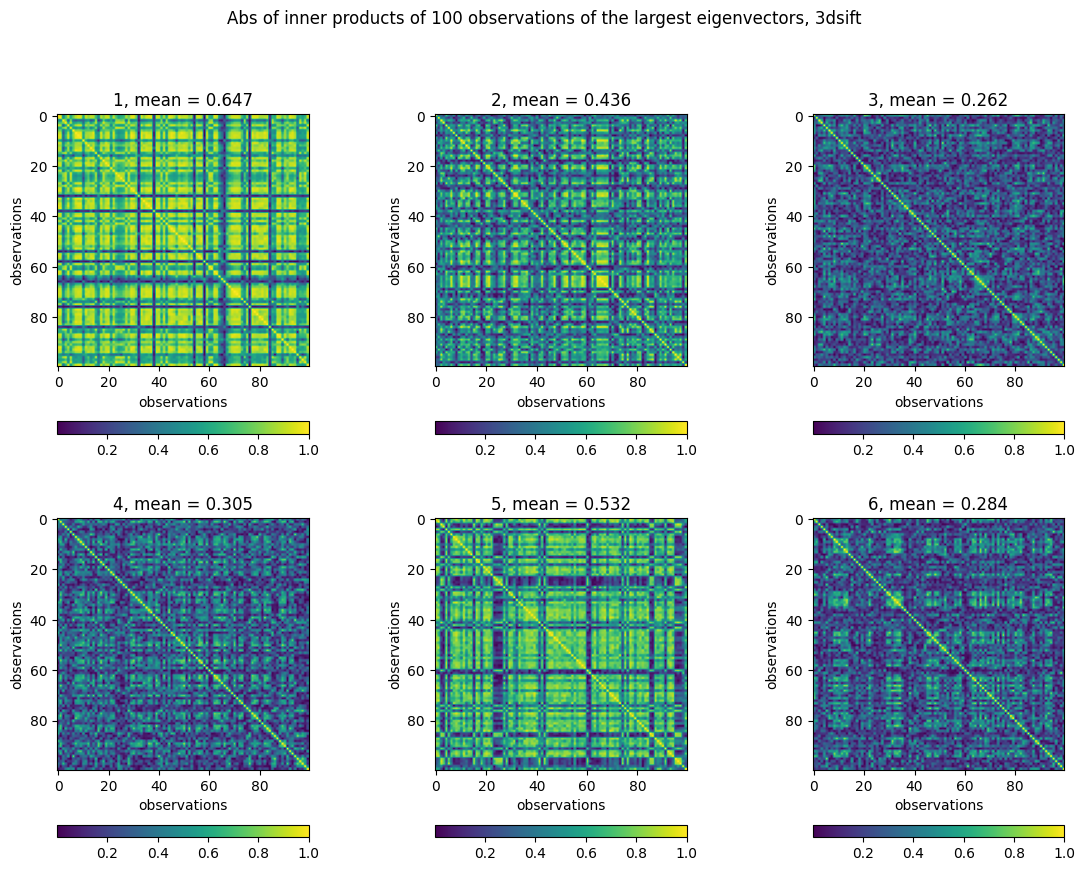

In [27]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    products = np.ones((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            products[i,j] = np.abs(np.dot(eigvecs_smth[i][:, vect_i], eigvecs_smth[j][:, vect_i]))
            products[j,i] = products[i,j]
            avg += np.abs(products[i,j])
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(products)
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('Abs of inner products of {} observations of the largest eigenvectors, {}'.format(num_M, feature_id))
plt.savefig('image/dotproducts.png',dpi=300, bbox_inches = "tight")

## Compute L2 norm of the difference of observations of an eigenvector

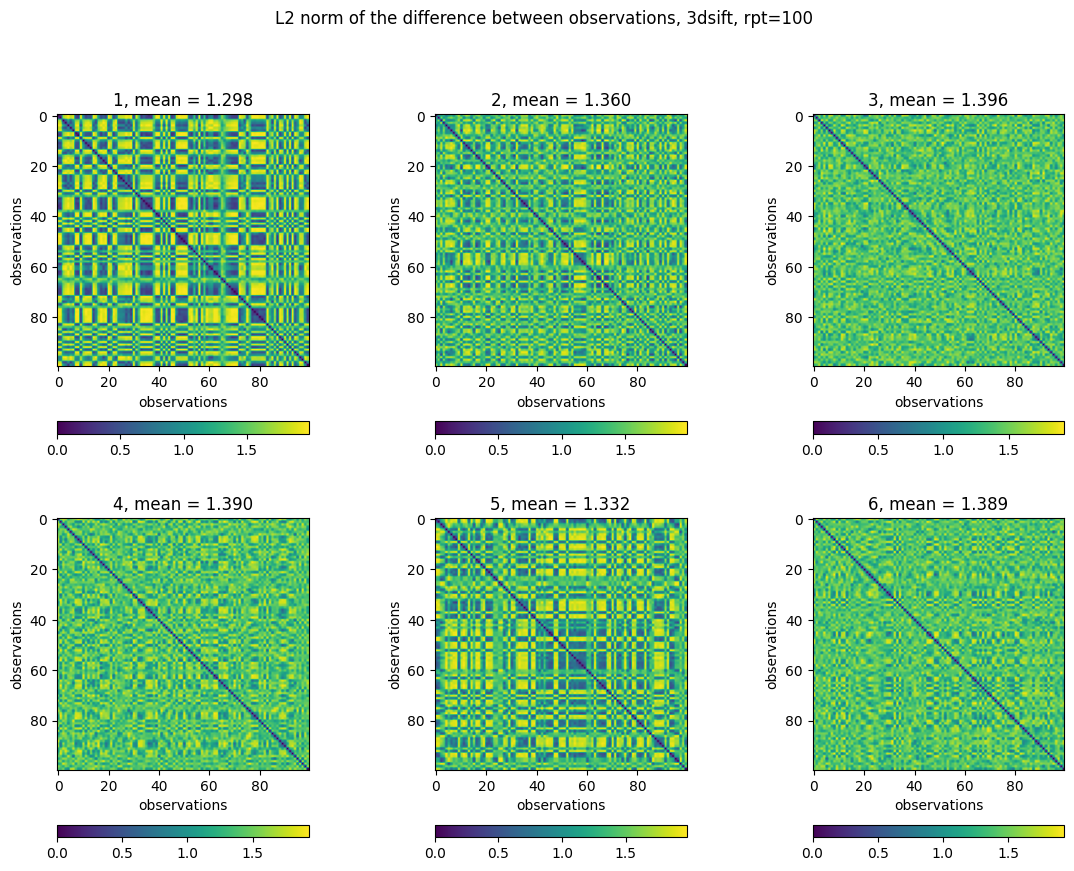

In [28]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    norms = np.zeros((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            norms[i,j] = np.linalg.norm(eigvecs_smth[i][:, vect_i] - eigvecs_smth[j][:, vect_i])
            norms[j,i] = norms[i,j]
            avg += norms[i,j]
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(norms)
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('L2 norm of the difference between observations, {}, rpt={}'.format(feature_id, num_M))
plt.savefig('image/norms.png',dpi=300, bbox_inches = "tight")

# Space of the most important eigenvectors

In [90]:
def project(orgSpace, projSpace):
    projs = np.zeros_like(orgSpace)
    for vect_i in range(orgSpace.shape[1]):
        # compute projection of orgSpace[:, vect_i] on projSpace
        proj_i = np.zeros_like(orgSpace[:, vect_i])
        for dim in range(projSpace.shape[1]):
            proj_i += np.dot(orgSpace[:, vect_i], projSpace[:, dim]) * projSpace[:, dim]
        projs[:, vect_i] = proj_i
    
    return projs

In [102]:
def projErr(eigvecs, ob_1, ob_2, num_eig, mode='avg', show_message=True):
    """
    mode: 'avg' for mean projection errors, 'max' for max errors, and 'org' for a stack of both errors.
    """
    
    A = np.real(eigvecs[ob_1][:, :num_eig])
    B = np.real(eigvecs[ob_2][:, :num_eig])
    if show_message:
        print('A = {}, cloumns of which are the {} largest eigenvectors of M in observation #{}'.format(A.shape, num_eig, ob_1))
        print('B = {}, cloumns of which are the {} largest eigenvectors of M in observation #{}'.format(B.shape, num_eig, ob_2))
    
    projA = project(A, B)
    if show_message:
        print('projA = {}, project of A columns on B\' column space.'.format(projA.shape))
    projB = project(B, A)
    if show_message:
        print('projB = {}, project of B columns on A\' column space.'.format(projB.shape))
    
    errA = np.linalg.norm(A - projA, axis=0)
    if show_message:
        print('errA = ', errA)
    errB = np.linalg.norm(B - projB, axis=0)
    if show_message:
        print('errB = ', errB)
    
    if mode == 'org':
        return np.stack((errA, errB), axis=0)
    elif mode == 'avg':
        return np.mean(np.stack((errA, errB), axis=0), axis=0)
    elif mode == 'max':
        return np.max(np.stack((errA, errB), axis=0), axis=0)

In [117]:
# compute the projection error of two observations for the 5 eigenvectors corresponding to the 5 largest eigenvalues
num_eig = 5
ob_1 = 26
ob_2 = 45

errAvg = projErr(eigvecs, ob_1, ob_2, num_eig, mode='avg', show_message=False)
print('errAvg = ', errAvg)

errMax = projErr(eigvecs, ob_1, ob_2, num_eig, mode='max', show_message=False)
print('errMax = ', errMax)

errAvg =  [0.94866869 0.98821569 0.98051719 0.99204304 0.98936812]
errMax =  [0.96091309 0.99538717 0.98054198 0.99532892 0.9906755 ]


## Visualize maximum projection errors between various observations

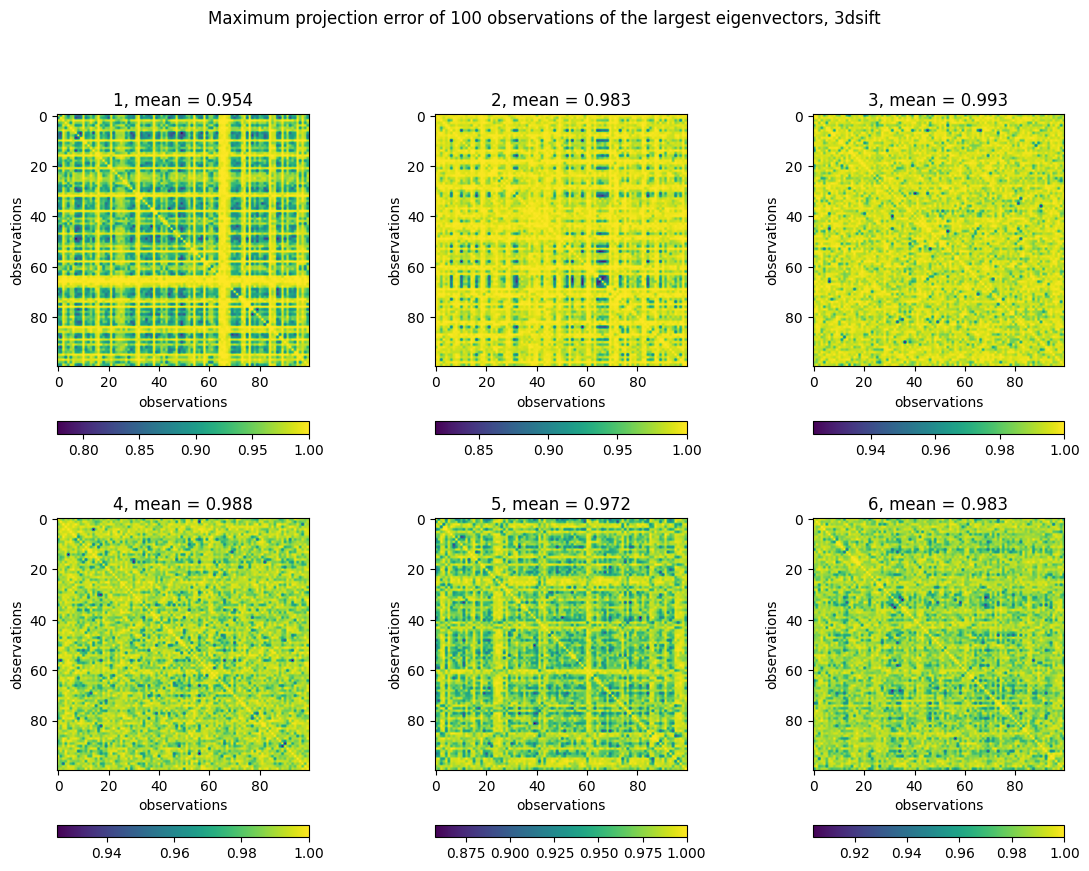

In [112]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    errsMax = np.ones((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            errsMax[i,j] = projErr(eigvecs, i, j, vect_i+1, mode='max', show_message=False)[-1]
            errsMax[j,i] = errsMax[i,j]
            avg += errsMax[i,j]
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(errsMax)
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('Maximum projection error of {} observations of the largest eigenvectors, {}'.format(num_M, feature_id))
plt.savefig('image/errMax.png',dpi=300, bbox_inches = "tight")

## Above - for smoothed eigenvectors

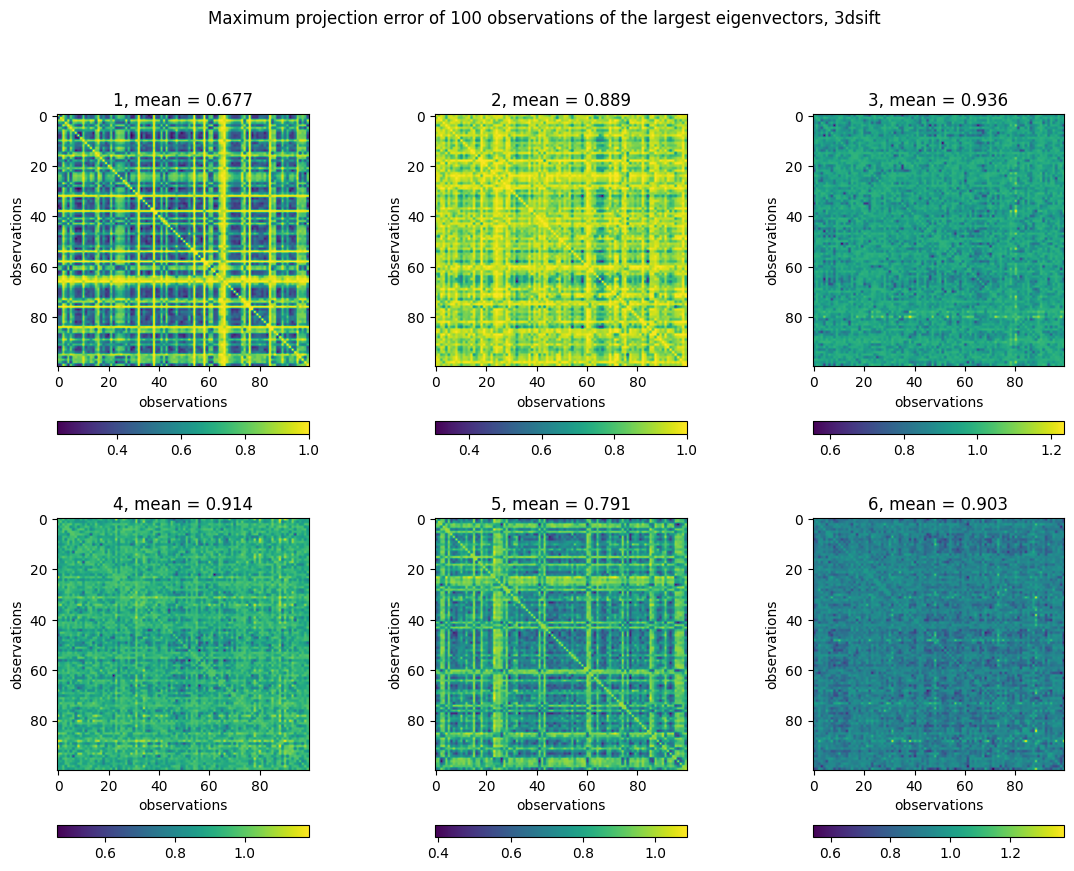

In [113]:
vect_i = 0 # which eigenvector is analyzed; vectors are indexed from 0 in descending order

plt.figure(figsize=(13, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.1)

for vect_i in range(6):
    avg = 0
    errsMax = np.ones((num_M, num_M))
    for i in range(num_M):
        for j in range(i+1, num_M):
            errsMax[i,j] = projErr(eigvecs_smth, i, j, vect_i+1, mode='max', show_message=False)[-1]
            errsMax[j,i] = errsMax[i,j]
            avg += errsMax[i,j]
    avg = 2 * avg / (num_M*(num_M-1))
    
    plt.subplot(2, 3, vect_i+1)
    plt.imshow(errsMax)
    plt.colorbar(location='bottom')
    plt.xlabel('observations')
    plt.ylabel('observations')
    plt.title('{}, mean = {:.3f}'.format(vect_i+1, avg))
    _ = plt.suptitle('Maximum projection error of {} observations of the largest eigenvectors, {}'.format(num_M, feature_id))
plt.savefig('image/errMax.png',dpi=300, bbox_inches = "tight")

# Categorize eigenvectors based on their similarity

Similarity between the eigenvectors corresponding to the largest eigenvalues can be seen with the naked eye. We want to mathematically illustrate this similarity with a proper metric.

Observations to be visualized =  [74 15 67 44 26 93  1 70 33]


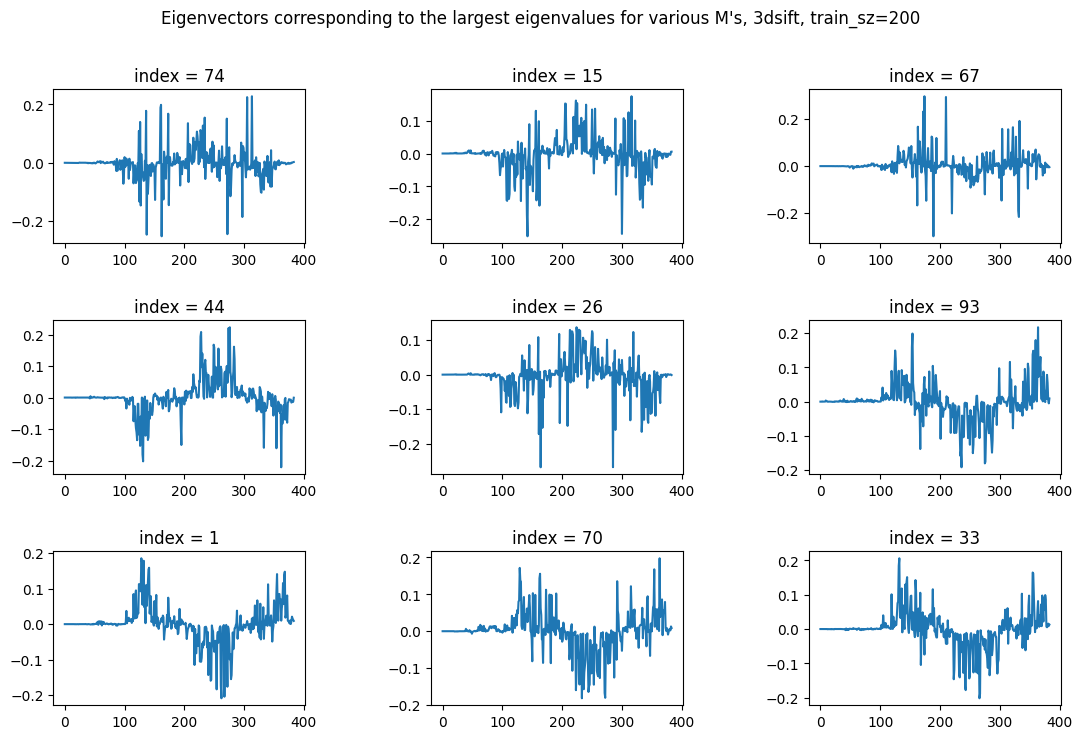

In [6]:
# similarity between the eigenvectors corresponding to the largest eigenvalues can be seen with the naked eye
# plot the largest eigenvector of the same observations
num_obs = 9 # number of observations to visualize
obs = np.random.choice(np.arange(num_M), size=num_obs, replace=False)
print('Observations to be visualized = ', obs)

x = np.arange(eigvecs[0].shape[0])
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for ob_i in obs:
    i += 1
    plt.subplot(3,num_obs//3,i)
    plt.plot(x, np.real(eigvecs[ob_i][:, 0]))
    plt.title('index = {}'.format(ob_i))

_ = plt.suptitle('Eigenvectors corresponding to the largest eigenvalues for various M\'s, {}, train_sz={}'.format(feature_id, train_sz))
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

## Simple dot product

In [7]:
def categorize(eigvecs, num_obs, min_score, vect_i=0):
    categories = {} # cat#: list of eigenvectors in the category
    
    for ob_i in range(num_obs):
        current = eigvecs[ob_i][:, vect_i]

        # find the average similarity of current to each category, and the most fitting category
        best_fit_cat = -1
        best_fit_score = -1
        scores = {} # average similarity of current to each category
        for cat in categories:
            scores[cat] = 0
            for member in categories[cat]:
                mem_score = np.abs(np.dot(member, current))
                scores[cat] += mem_score
            scores[cat] /= len(categories[cat])

            if scores[cat] > min_score and scores[cat] > best_fit_score:
                best_fit_score = scores[cat]
                best_fit_cat = cat

        if best_fit_cat == -1:
            # if current is dissimilar to all categories, create a new category
            categories[len(categories)+1] = [current]
        else:
            # assign current to the most similar category
            categories[best_fit_cat].append(current)
    
    return categories

In [79]:
min_score = 0.3 # determines membership into a category
categories = categorize(eigvecs, num_M, min_score)
print('categories = {} x list of vectors of shape {} '.format(len(categories), categories[1][0].shape), '= {cat#: list of vectors}')

categories = 30 x list of vectors of shape (384,)  = {cat#: list of vectors}


### Show statistics

In [80]:
def get_statistics(categories, show_dist=True):
    num_cats = len(categories)
    
    num_mems = {}
    for cat in categories:
        num_mems[cat] = len(categories[cat])
    
    if show_dist:
        plt.figure()
        plt.bar(num_mems.keys(), num_mems.values(), tick_label=list(num_mems.keys()))
        plt.title('Distribution of Eigenvectors in Various Categories')
        plt.xlabel('category index')
        _ = plt.ylabel('# of eigenvectors in the category')
        plt.show()
        
    return num_cats, num_mems

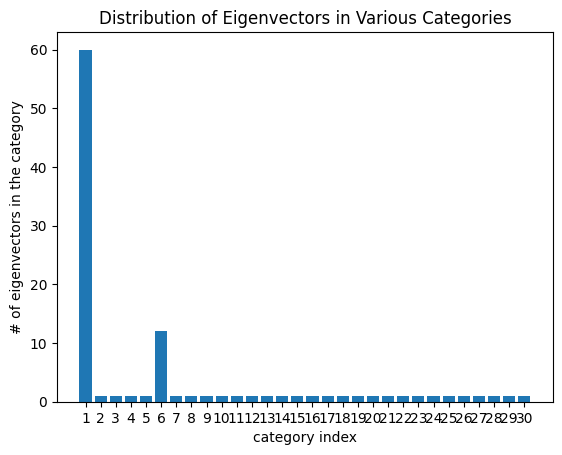

# of cats found =  30
# of members in each category:
 {1: 60, 2: 1, 3: 1, 4: 1, 5: 1, 6: 12, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1}


In [81]:
num_cats, num_mems = get_statistics(categories)
print('# of cats found = ', num_cats)
print('# of members in each category:\n', num_mems)

### Merge specific categories

In [58]:
def merge_cats(categories, to_merge_list):
    catcpy = {} # new categories
    bucket = [] # temporary hold for merged members
    count = 1
    for cat in categories:
        if cat in to_merge_list:
            # put members in the bucket
            bucket.extend(categories[cat])
        else:
            # relay the category unchanged
            catcpy[count] = categories[cat]
            count += 1
    catcpy[count] = bucket # the last categorie is the merged one
    return catcpy

In [59]:
# get categories with only one member
single_cats = np.array(list(num_mems.keys()))
single_cats = single_cats[np.array(list(num_mems.values())) == 1]
print('categories with only one member:', single_cats)

categories with only one member: [ 2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30]


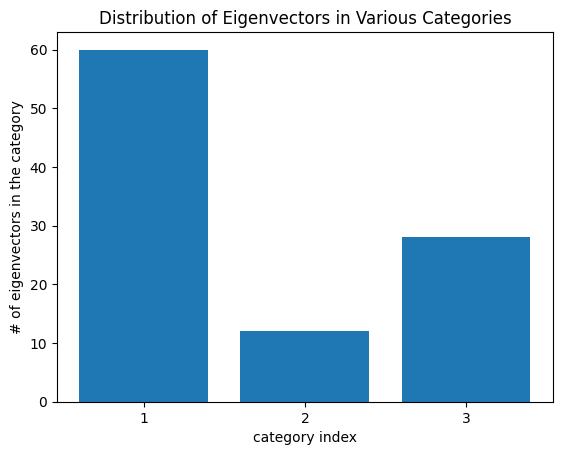

# of cats found =  3
# of members in each category:
 {1: 60, 2: 12, 3: 28}


In [60]:
# merge all unmatched categories together
catcpy = merge_cats(categories, single_cats)

num_cats_cpy, num_mems_cpy = get_statistics(catcpy)
print('# of cats found = ', num_cats_cpy)
print('# of members in each category:\n', num_mems_cpy)

### Merge misfits

In [95]:
def merge_misfits(categories, min_cat_sz):
    temp = np.array(list(num_mems.values()))
    to_merge_list = np.array(list(num_mems.keys()))
    to_merge_list = to_merge_list[temp < min_cat_sz]
    
    return merge_cats(categories, to_merge_list)

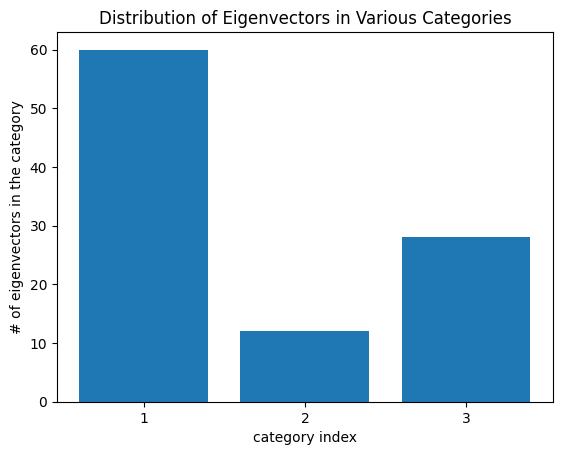

# of cats found =  3
# of members in each category:
 {1: 60, 2: 12, 3: 28}


In [96]:
catcpy2 = merge_misfits(categories, min_cat_sz=2)
num_cats_cpy2, num_mems_cpy2 = get_statistics(catcpy2)
print('# of cats found = ', num_cats_cpy2)
print('# of members in each category:\n', num_mems_cpy2)

### Compute the average dot product for each category

In [97]:
def dots4cats(categories):
    avg_dots = {} # holds the average absolute value of dot products between pairs of eigenvectors
    for cat in categories:
        vec_list = categories[cat]
        avg_sim = 0
        
        if len(vec_list) > 1:
            for i in range(len(vec_list)):
                for j in range(i+1, len(vec_list)):
                    avg_sim += np.abs(np.dot(vec_list[i], vec_list[j]))
            avg_sim /= (len(vec_list)*(len(vec_list)-1)/2)
        
        avg_dots[cat] = avg_sim
    return avg_dots

average dot products in each category:
 {1: 0.41443302576511687, 2: 0.3954688364090881, 3: 0.07162414326762101}


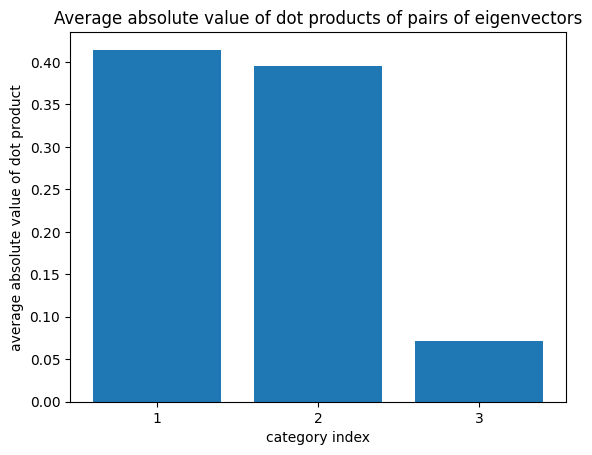

In [98]:
catdots = dots4cats(catcpy2)
print('average dot products in each category:\n', catdots)

plt.figure()
plt.bar(catdots.keys(), catdots.values(), tick_label=list(catdots.keys()))
plt.title('Average absolute value of dot products of pairs of eigenvectors')
plt.xlabel('category index')
_ = plt.ylabel('average absolute value of dot product')
plt.show()

### Illustrate categories

In [64]:
def illustrate_cats(categories, to_illustrate=None, res_path=''):
    x = np.arange(categories[1][0].shape[0])
    if to_illustrate is None:
        to_illustrate = list(categories.keys())
    
    # prepare the folder tree
    if os.path.exists(res_path+'categories/'):
        shutil.rmtree(res_path+'categories/')
    os.mkdir(res_path+'categories/')
    for cat in to_illustrate:
        if not os.path.exists(res_path+'categories/cat_'+str(cat)+'/'):
            os.mkdir(res_path+'categories/cat_'+str(cat)+'/')

        i = 1
        for member in categories[cat]:
            plt.figure()
            plt.plot(x, np.real(member))
            plt.title('Member #{} of Categorie #{}'.format(i, cat))
            plt.xlabel('index')
            plt.ylabel('eigenvector samples')
            plt.savefig(res_path+'categories/cat_'+str(cat)+'/'+'mem_'+str(i)+'.png',dpi=300, bbox_inches = 'tight')
            plt.close()
            i += 1

In [68]:
illustrate_cats(categories, to_illustrate=[1, 6])
# illustrate_cats(catcpy2, to_illustrate=None)

## Moving average + dot product

In [76]:
min_score = 0.3 # determines membership into a category
categories_smth = categorize(eigvecs_smth, num_M, min_score)
print('categories_smth = {} x list of vectors of shape {} '.format(len(categories_smth), categories_smth[1][0].shape), '= {cat#: list of vectors}')

categories_smth = 9 x list of vectors of shape (384,)  = {cat#: list of vectors}


### Show statistics

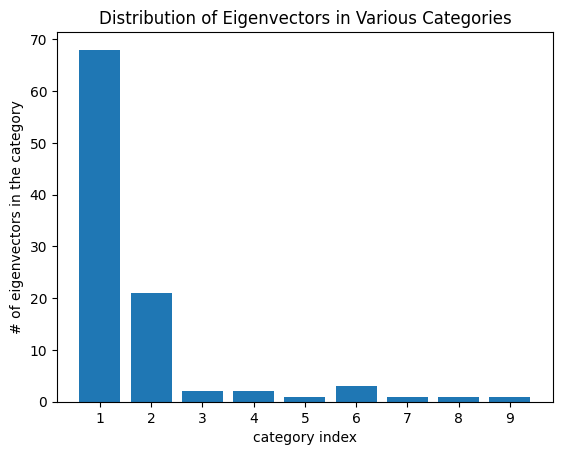

# of cats found =  9
# of members in each category:
 {1: 68, 2: 21, 3: 2, 4: 2, 5: 1, 6: 3, 7: 1, 8: 1, 9: 1}


In [88]:
num_cats_smth, num_mems_smth = get_statistics(categories_smth)
print('# of cats found = ', num_cats_smth)
print('# of members in each category:\n', num_mems_smth)

### Merge misfits

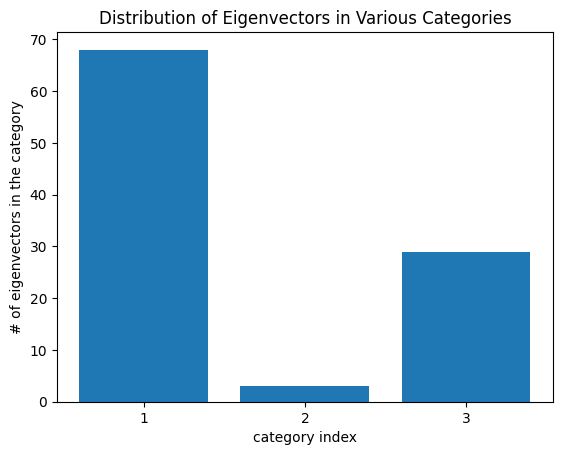

# of cats found =  3
# of members in each category:
 {1: 68, 2: 3, 3: 29}


In [92]:
catcpy_smth = merge_misfits(categories_smth, min_cat_sz=2)
num_cats_cpy_smth, num_mems_cpy_smth = get_statistics(catcpy_smth)
print('# of cats found = ', num_cats_cpy_smth)
print('# of members in each category:\n', num_mems_cpy_smth)

### Compute the average dot product for each category

average dot products in each category:
 {1: 0.6565195738421465, 2: 0.3553635054585202, 3: 0.3727083246211669}


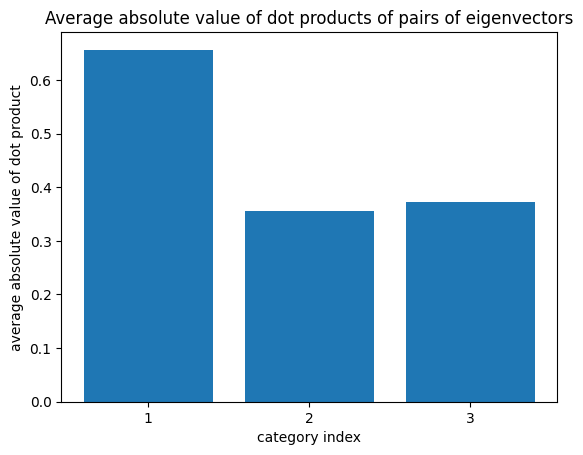

In [93]:
catdots_smth = dots4cats(catcpy_smth)
print('average dot products in each category:\n', catdots_smth)

plt.figure()
plt.bar(catdots_smth.keys(), catdots_smth.values(), tick_label=list(catdots_smth.keys()))
plt.title('Average absolute value of dot products of pairs of eigenvectors')
plt.xlabel('category index')
_ = plt.ylabel('average absolute value of dot product')
plt.show()

### Illustrate categories

In [94]:
# illustrate_cats(categories_smth, to_illustrate=[1, 2])
illustrate_cats(catcpy_smth, to_illustrate=None)

## Bandstop filter + dot product

In [105]:
ob_i = 0
N = eigvecs[0].shape[0]
eigvecs_fft = fft(eigvecs[0], axis=0)

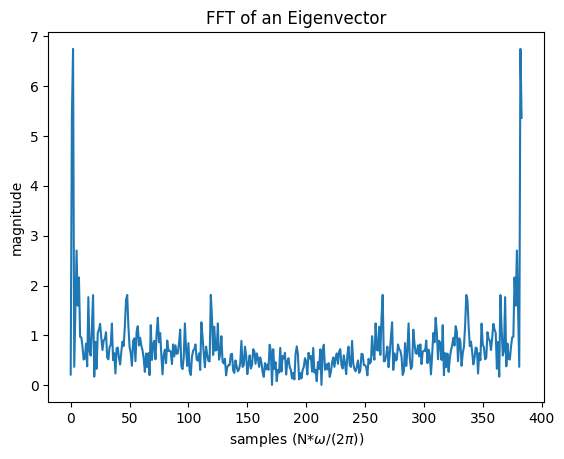

In [118]:
plt.plot(np.arange(N), np.abs(eigvecs_fft[:, 0]))
plt.xlabel('samples (N*$\omega$/(2$\pi$))')
plt.ylabel('magnitude')
_ = plt.title('FFT of an Eigenvector')
plt.show()

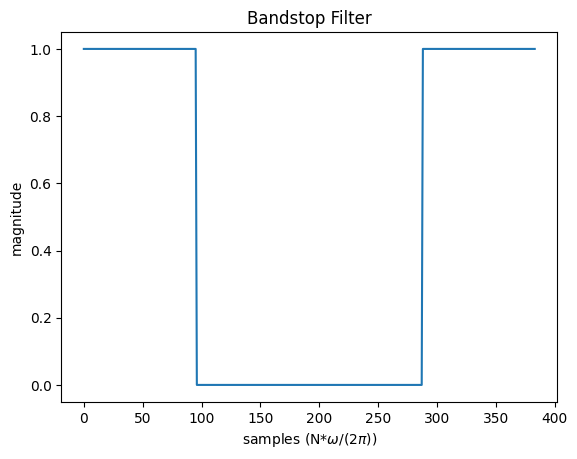

In [140]:
wstop_pi = 0.5
wstart_pi = 1.0

bandstop = np.ones(N)
bandstop[int(wstop_pi*N/2):int(wstart_pi*N/2)] = 0
bandstop[N-int(wstart_pi*N/2):N-int(wstop_pi*N/2)] = 0
plt.plot(np.arange(N), bandstop)
plt.xlabel('samples (N*$\omega$/(2$\pi$))')
plt.ylabel('magnitude')
_ = plt.title('Bandstop Filter')
plt.show()

In [141]:
# apply filter on the signal
eigvecs_bsf_fft = np.matmul(np.diag(bandstop), eigvecs_fft)

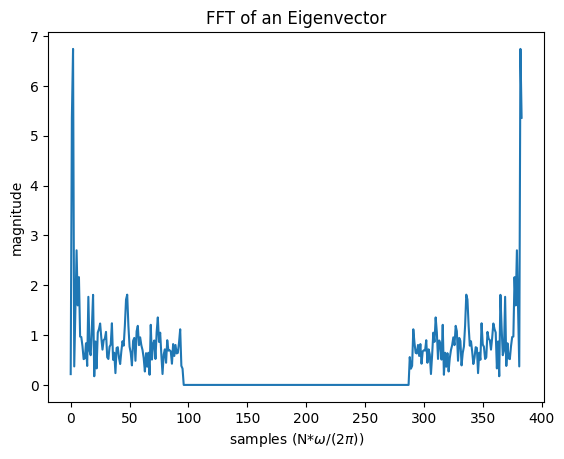

In [142]:
plt.plot(np.arange(N), np.abs(eigvecs_bsf_fft[:, 0]))
plt.xlabel('samples (N*$\omega$/(2$\pi$))')
plt.ylabel('magnitude')
_ = plt.title('FFT of an Eigenvector')
plt.show()

In [143]:
eigvecs_bsf = []
eigvecs_bsf.append(ifft(eigvecs_bsf_fft, axis=0))

### visualize filtered eigenvectors

Text(0.5, 1.0, 'index = 74')

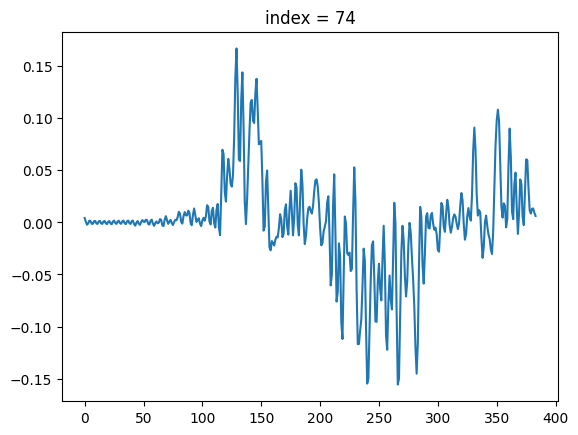

In [145]:
plt.plot(x, np.real(eigvecs_bsf[0][:, 0]))
plt.title('index = {}'.format(ob_i))

Text(0.5, 1.0, 'index = 74')

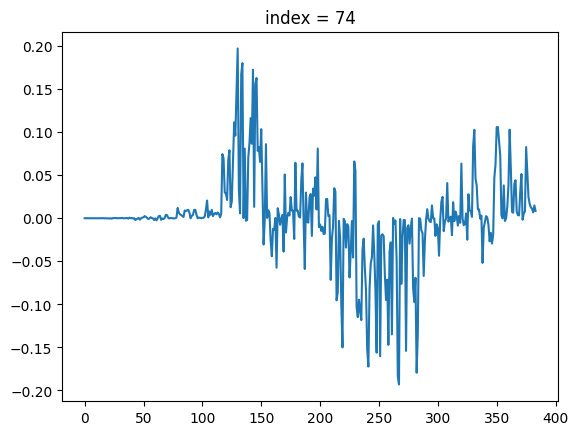

In [146]:
plt.plot(x, np.real(eigvecs[0][:, 0]))
plt.title('index = {}'.format(ob_i))